<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/GymLens_Training_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset Cropped'

Mounted at /content/drive


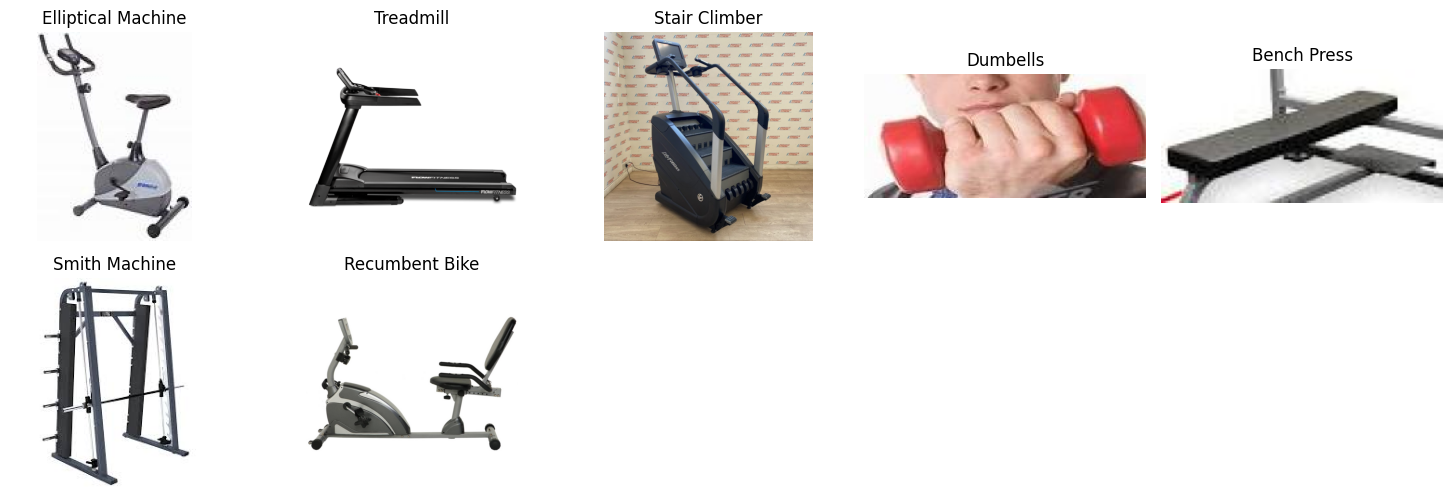

In [3]:
# Function to preprocess and handle images
def preprocess_image(image_path):
    """
    Open an image, convert to RGBA format if necessary, and return the processed image.
    """
    img = Image.open(image_path)
    if img.mode in ('P', 'L') or ('transparency' in img.info):
        img = img.convert('RGBA')
    return img

# Function to display sample images
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = preprocess_image(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Display sample images
display_sample_images(DATASET_DIR)


In [4]:
# Data Generators
batch_size = 128
train_datagen = ImageDataGenerator(
    validation_split=0.2,  # Split 20% for validation
    rescale=1.0 / 255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),  # Smaller input size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print("Number of classes:", len(train_generator.class_indices))
print("Number of training images:", train_generator.n)
print("Number of validation images:", validation_generator.n)


Found 876 images belonging to 7 classes.
Found 216 images belonging to 7 classes.
Number of classes: 7
Number of training images: 876
Number of validation images: 216


In [5]:
# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to speed up training

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.98)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4615 - loss: 1.7728

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 426s 19s/step - accuracy: 0.5231 - loss: 1.6301 - val_accuracy: 0.9028 - val_loss: 0.4369
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 897ms/step - accuracy: 0.9165 - loss: 0.2939 - val_accuracy: 0.9398 - val_loss: 0.1901
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - accuracy: 0.9588 - loss: 0.1182 - val_accuracy: 0.9676 - val_loss: 0.0871
Epoch 4/5
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9813 - loss: 0.0544
Stopping training as validation accuracy reached 0.99 (≥ 0.98)
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.9811 - loss: 0.0555 - val_accuracy: 0.9861 - val_loss: 0.0745


In [8]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9597 - loss: 0.1033
Validation Loss: 0.09368886798620224
Validation Accuracy: 0.9629629850387573


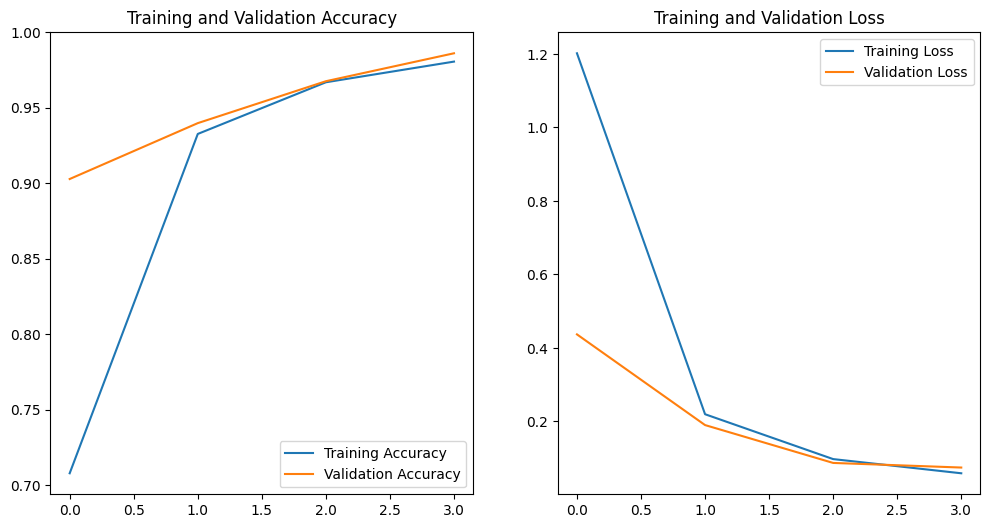

In [9]:
# Plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


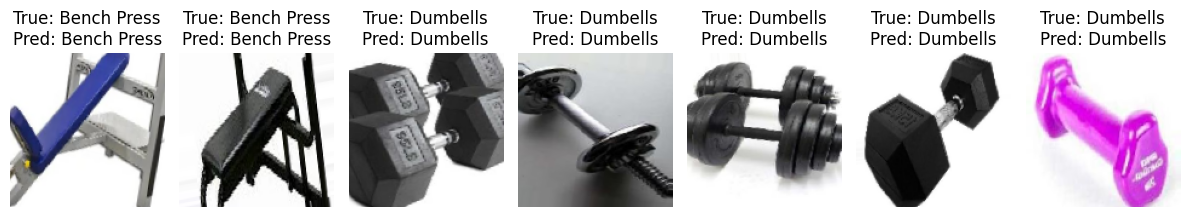

In [17]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=7):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ipywidgets import FileUpload
from PIL import Image
import io # Import the 'io' module

def upload_and_test(model, target_size, class_indices):
    """
    Upload file, preprocess, and predict using the trained model.

    Parameters:
    - model: Trained Keras model.
    - target_size: Tuple (width, height) for resizing the input image.
    - class_indices: Dictionary of class labels and indices.

    Returns:
    None
    """
    # Upload file widget
    uploader = FileUpload(accept='image/*', multiple=False)
    display(uploader)

    def on_upload(change):
        # Load and preprocess the uploaded image
        for name, file_info in uploader.value.items():
            img = Image.open(io.BytesIO(file_info['content'])) # 'io' is now defined
            img = img.resize(target_size)  # Resize image to match model input size
            img_array = img_to_array(img) / 255.0  # Normalize image data
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

            # Predict
            prediction = model.predict(img_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]
            confidence = np.max(prediction)

            # Show the uploaded image and prediction
            plt.imshow(img)
            plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
            plt.axis('off')
            plt.show()

    uploader.observe(on_upload, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


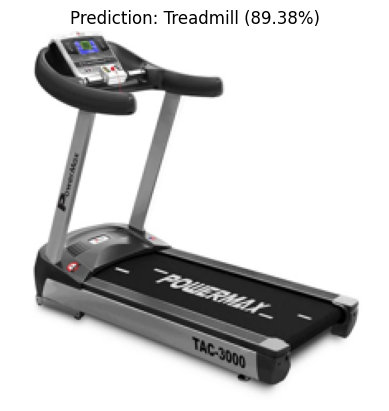

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


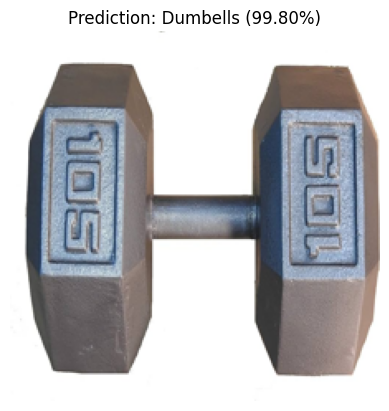

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


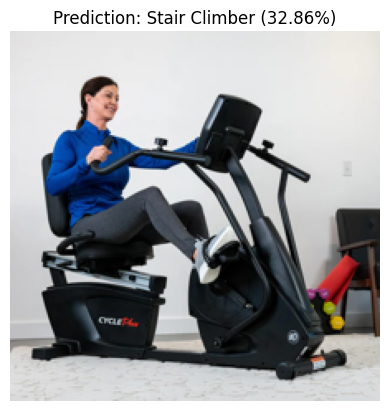

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


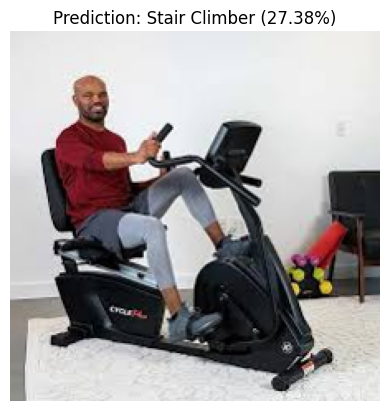

In [22]:
upload_and_test(model, target_size=(224, 224), class_indices=validation_generator.class_indices)


In [23]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5
